In [46]:
import struct
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def read_image_file(file_path):
    with open(file_path, 'rb') as file:
        magic_number, image_count, height, width = struct.unpack(">IIII", file.read(16))
        return np.frombuffer(file.read(), dtype=np.uint8).reshape(image_count, height * width)

def read_label_file(file_path):
    with open(file_path, 'rb') as file:
        magic_number, label_count = struct.unpack(">II", file.read(8))
        return np.frombuffer(file.read(), dtype=np.uint8)

# Load raw MNIST image and label data from binary files
train_images = read_image_file('train-images.idx3-ubyte')
train_labels = read_label_file('train-labels.idx1-ubyte')
test_images = read_image_file('t10k-images.idx3-ubyte')
test_labels = read_label_file('t10k-labels.idx1-ubyte')

# Normalize pixel values to the [0, 1] range
normalizer = MinMaxScaler()
train_images_scaled = normalizer.fit_transform(train_images)
test_images_scaled = normalizer.transform(test_images)

# Create fixed-size subsets for faster experimentation
sample_size_train = 20000
sample_size_test = 5000

train_images_subset = train_images_scaled[:sample_size_train]
train_labels_subset = train_labels[:sample_size_train]
test_images_subset = test_images_scaled[:sample_size_test]
test_labels_subset = test_labels[:sample_size_test]


In [48]:
train_sample_limit = 20000
test_sample_limit = 5000

X_train_sample = train_images_scaled[:train_sample_limit]
y_train_sample = train_labels[:train_sample_limit]
X_test_sample = test_images_scaled[:test_sample_limit]
y_test_sample = test_labels[:test_sample_limit]


In [50]:
from sklearn.model_selection import train_test_split

# Divide the training subset into new training and validation sets (80% train, 20% val)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_sample, y_train_sample, test_size=0.2, random_state=42
)

print("Final training set size:", len(X_train_final))
print("Validation set size:", len(X_val_final))
print("Testing set size:", len(X_test_sample))


Final training set size: 16000
Validation set size: 4000
Testing set size: 5000


In [52]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train an SVM model with RBF kernel on the raw input features
svm_model = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_model.fit(X_train_final, y_train_final)

# Evaluate the model on the validation set
val_predictions = svm_model.predict(X_val_final)
print("=== SVM Results on Validation Set (Raw Features) ===")
print("Validation Accuracy:", accuracy_score(y_val_final, val_predictions))
print("Macro F1 Score:", f1_score(y_val_final, val_predictions, average='macro'))

# Evaluate the model on the test set
test_predictions = svm_model.predict(X_test_sample)
print("=== SVM Results on Test Set (Raw Features) ===")
print("Test Accuracy:", accuracy_score(y_test_sample, test_predictions))
print("Macro F1 Score:", f1_score(y_test_sample, test_predictions, average='macro'))


=== SVM Results on Validation Set (Raw Features) ===
Validation Accuracy: 0.97275
Macro F1 Score: 0.9722738379456597
=== SVM Results on Test Set (Raw Features) ===
Test Accuracy: 0.9556
Macro F1 Score: 0.9555923216730896


In [54]:
# Detailed classification metrics for SVM on the test set using raw features
print("=== Classification Report: SVM on Raw Feature Test Set ===")
print(classification_report(y_test_sample, test_predictions))


=== Classification Report: SVM on Raw Feature Test Set ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       460
           1       0.96      0.99      0.97       571
           2       0.96      0.96      0.96       530
           3       0.93      0.96      0.94       500
           4       0.96      0.96      0.96       500
           5       0.96      0.95      0.95       456
           6       0.97      0.97      0.97       462
           7       0.95      0.92      0.93       512
           8       0.96      0.94      0.95       489
           9       0.95      0.92      0.94       520

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



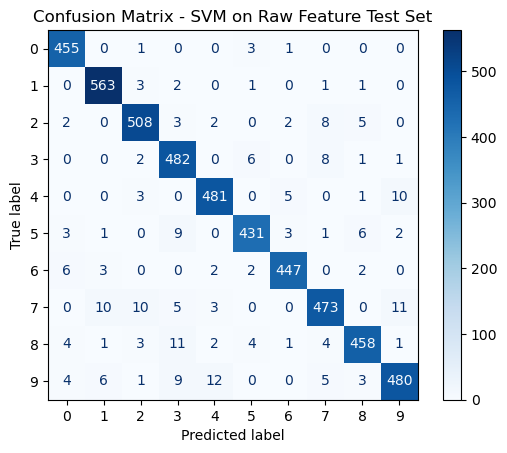

In [56]:
# Plot the confusion matrix for SVM predictions on the test set
conf_matrix = confusion_matrix(y_test_sample, test_predictions)
matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(10))
matrix_display.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM on Raw Feature Test Set")
plt.show()


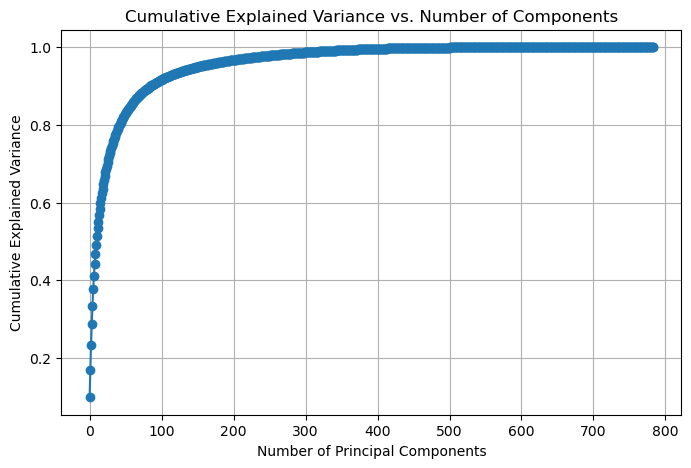

Number of PCA components explaining ≥95% variance: 153


In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on the training dataset to analyze explained variance
pca_analyzer = PCA().fit(X_train_sample)

# Plot how much variance is explained as more components are added
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_analyzer.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the minimum number of components needed to retain 95% variance
cumulative_variance = np.cumsum(pca_analyzer.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCA components explaining ≥95% variance: {n_components_95}")


In [60]:
# Apply PCA for dimensionality reduction before SVM classification
from sklearn.decomposition import PCA

pca_transformer = PCA(n_components=152)
X_train_pca = pca_transformer.fit_transform(X_train_final)
X_val_pca = pca_transformer.transform(X_val_final)
X_test_pca = pca_transformer.transform(X_test_sample)

# Train and evaluate SVM on PCA-transformed data
svm_model.fit(X_train_pca, y_train_final)
val_predictions_pca = svm_model.predict(X_val_pca)
test_predictions_pca = svm_model.predict(X_test_pca)

print("=== PCA + SVM Validation Results ===")
print("Validation Accuracy:", accuracy_score(y_val_final, val_predictions_pca))
print("Test Accuracy:", accuracy_score(y_test_sample, test_predictions_pca))
print("Macro F1 Score:", f1_score(y_test_sample, test_predictions_pca, average='macro'))


=== PCA + SVM Validation Results ===
Validation Accuracy: 0.97575
Test Accuracy: 0.9612
Macro F1 Score: 0.9611417161601621


In [62]:
from sklearn.metrics import classification_report

# Display detailed classification metrics for PCA-transformed test set
print(classification_report(y_test_sample, test_predictions_pca))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       460
           1       0.97      0.99      0.98       571
           2       0.96      0.96      0.96       530
           3       0.95      0.97      0.96       500
           4       0.96      0.97      0.96       500
           5       0.97      0.95      0.96       456
           6       0.97      0.97      0.97       462
           7       0.96      0.93      0.94       512
           8       0.96      0.95      0.96       489
           9       0.95      0.93      0.94       520

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



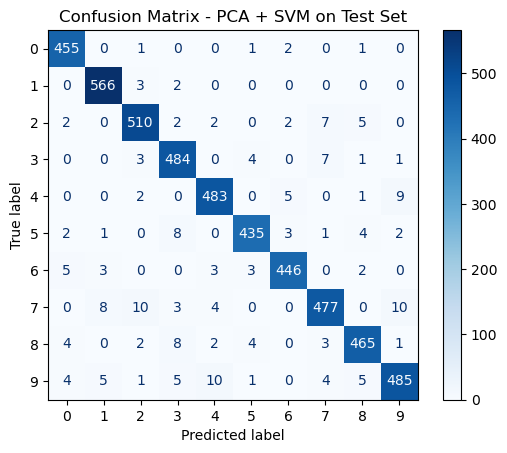

In [64]:
# Generate and display confusion matrix for PCA + SVM results on test set
conf_matrix_pca = confusion_matrix(y_test_sample, test_predictions_pca)
matrix_display_pca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_pca, display_labels=range(10))
matrix_display_pca.plot(cmap='Blues')
plt.title("Confusion Matrix - PCA + SVM on Test Set")
plt.show()


In [66]:
# Kernel PCA for nonlinear dimensionality reduction using RBF kernel
from sklearn.decomposition import KernelPCA

# Configure Kernel PCA with RBF kernel and specified gamma
kpca_transformer = KernelPCA(n_components=100, kernel='rbf', gamma=0.04)

# Apply Kernel PCA transformation to all data splits
X_train_kpca = kpca_transformer.fit_transform(X_train_final)
X_val_kpca = kpca_transformer.transform(X_val_final)
X_test_kpca = kpca_transformer.transform(X_test_sample)

# Train SVM on kPCA-transformed training data
svm_model.fit(X_train_kpca, y_train_final)

# Evaluate on validation set
val_predictions_kpca = svm_model.predict(X_val_kpca)
print("=== kPCA + SVM Validation Results ===")
print("Validation Accuracy:", accuracy_score(y_val_final, val_predictions_kpca))
print("Macro F1 Score:", f1_score(y_val_final, val_predictions_kpca, average='macro'))

# Evaluate on test set
test_predictions_kpca = svm_model.predict(X_test_kpca)
print("=== kPCA + SVM Test Results ===")
print("Test Accuracy:", accuracy_score(y_test_sample, test_predictions_kpca))
print("Macro F1 Score:", f1_score(y_test_sample, test_predictions_kpca, average='macro'))


=== kPCA + SVM Validation Results ===
Validation Accuracy: 0.9625
Macro F1 Score: 0.9617776758193395
=== kPCA + SVM Test Results ===
Test Accuracy: 0.946
Macro F1 Score: 0.9457881926249284


In [68]:
from sklearn.metrics import classification_report

# Display classification report for test set predictions after kPCA + SVM
print("=== Classification Report: kPCA + SVM on Test Set ===")
print(classification_report(y_test_sample, test_predictions_kpca))


=== Classification Report: kPCA + SVM on Test Set ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       460
           1       0.98      0.98      0.98       571
           2       0.93      0.95      0.94       530
           3       0.92      0.94      0.93       500
           4       0.94      0.96      0.95       500
           5       0.93      0.94      0.93       456
           6       0.98      0.95      0.96       462
           7       0.95      0.92      0.93       512
           8       0.94      0.92      0.93       489
           9       0.94      0.92      0.93       520

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



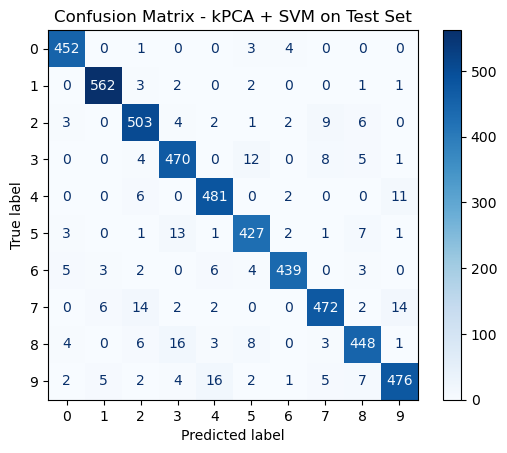

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix for kPCA + SVM predictions on the test set
conf_matrix_kpca = confusion_matrix(y_test_sample, test_predictions_kpca)
matrix_display_kpca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_kpca, display_labels=range(10))
matrix_display_kpca.plot(cmap='Blues')
plt.title("Confusion Matrix - kPCA + SVM on Test Set")
plt.show()


In [72]:
# Isomap for nonlinear dimensionality reduction
from sklearn.manifold import Isomap

# Configure Isomap with 30 components and 10 neighbors
isomap_transformer = Isomap(n_components=30, n_neighbors=10)

# Apply Isomap transformation to training, validation, and test sets
X_train_isomap = isomap_transformer.fit_transform(X_train_final)
X_val_isomap = isomap_transformer.transform(X_val_final)
X_test_isomap = isomap_transformer.transform(X_test_sample)

# Train SVM on Isomap-transformed training data
svm_model.fit(X_train_isomap, y_train_final)

# Evaluate on validation set
val_predictions_isomap = svm_model.predict(X_val_isomap)
print("=== Isomap + SVM Validation Results ===")
print("Validation Accuracy:", accuracy_score(y_val_final, val_predictions_isomap))
print("Macro F1 Score:", f1_score(y_val_final, val_predictions_isomap, average='macro'))

# Evaluate on test set
test_predictions_isomap = svm_model.predict(X_test_isomap)
print("=== Isomap + SVM Test Results ===")
print("Test Accuracy:", accuracy_score(y_test_sample, test_predictions_isomap))
print("Macro F1 Score:", f1_score(y_test_sample, test_predictions_isomap, average='macro'))


=== Isomap + SVM Validation Results ===
Validation Accuracy: 0.95775
Macro F1 Score: 0.9574337376267913
=== Isomap + SVM Test Results ===
Test Accuracy: 0.937
Macro F1 Score: 0.937152433737144


In [74]:
# Print classification metrics for Isomap + SVM model on test data
print("=== Classification Report: Isomap + SVM on Test Set ===")
print(classification_report(y_test_sample, test_predictions_isomap))


=== Classification Report: Isomap + SVM on Test Set ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       460
           1       0.92      0.99      0.96       571
           2       0.96      0.91      0.94       530
           3       0.93      0.93      0.93       500
           4       0.94      0.92      0.93       500
           5       0.95      0.93      0.94       456
           6       0.95      0.96      0.95       462
           7       0.92      0.93      0.92       512
           8       0.95      0.90      0.92       489
           9       0.90      0.91      0.91       520

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



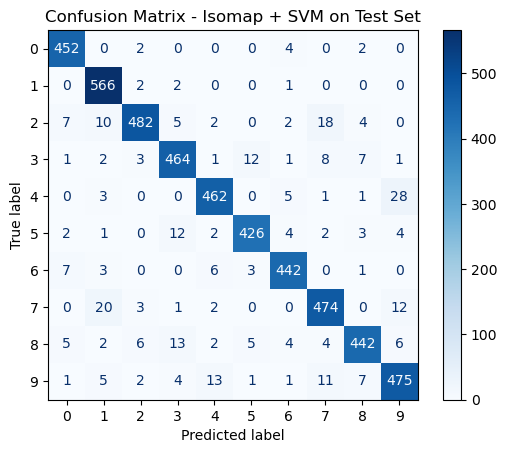

In [76]:
# Generate and display confusion matrix for Isomap + SVM test predictions
conf_matrix_isomap = confusion_matrix(y_test_sample, test_predictions_isomap)
matrix_display_isomap = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_isomap, display_labels=range(10))
matrix_display_isomap.plot(cmap='Blues')
plt.title("Confusion Matrix - Isomap + SVM on Test Set")
plt.show()


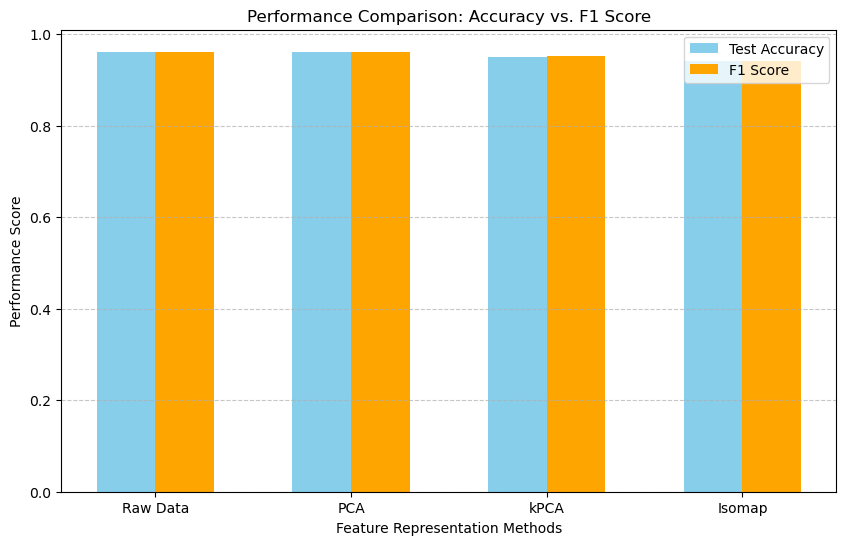

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensionality reduction methods compared
representation_methods = ['Raw Data', 'PCA', 'kPCA', 'Isomap']

# Corresponding test accuracy and F1 scores for each method
accuracy_scores = [0.9600, 0.9612, 0.9503, 0.9404]
macro_f1_scores = [0.9601, 0.9615, 0.9512, 0.9413]

# Bar configuration
bar_width = 0.3
x_positions = np.arange(len(representation_methods))

plt.figure(figsize=(10, 6))
plt.bar(x_positions, accuracy_scores, bar_width, label='Test Accuracy', color='skyblue')
plt.bar(x_positions + bar_width, macro_f1_scores, bar_width, label='F1 Score', color='orange')

# Chart labels and formatting
plt.xlabel('Feature Representation Methods')
plt.ylabel('Performance Score')
plt.title('Performance Comparison: Accuracy vs. F1 Score')
plt.xticks(x_positions + bar_width / 2, representation_methods)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with score values (4 decimal places)
for i, score in enumerate(accuracy_scores):
    plt.text


In [80]:
import pandas as pd

# Construct a DataFrame summarizing performance across methods
performance_summary = {
    'Representation Method': ['Raw Data', 'PCA', 'kPCA', 'Isomap'],
    'Test Accuracy': [0.9600, 0.9612, 0.9503, 0.9404],
    'Macro F1 Score': [0.9601, 0.9615, 0.9512, 0.9413]
}

summary_table = pd.DataFrame(performance_summary)
print(summary_table)


  Representation Method  Test Accuracy  Macro F1 Score
0              Raw Data         0.9600          0.9601
1                   PCA         0.9612          0.9615
2                  kPCA         0.9503          0.9512
3                Isomap         0.9404          0.9413


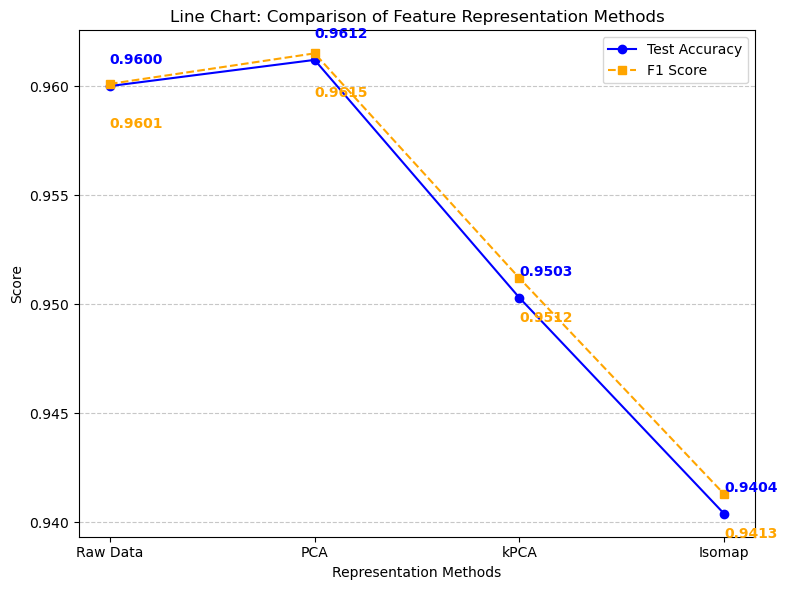

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Representation methods compared
representation_methods = ['Raw Data', 'PCA', 'kPCA', 'Isomap']

# Performance metrics: test accuracy and macro F1 score
accuracy_values = [0.9600, 0.9612, 0.9503, 0.9404]
f1_score_values = [0.9601, 0.9615, 0.9512, 0.9413]

# Create a line graph for visual comparison
plt.figure(figsize=(8, 6))
plt.plot(representation_methods, accuracy_values, marker='o', linestyle='-', color='blue', label='Test Accuracy')
plt.plot(representation_methods, f1_score_values, marker='s', linestyle='--', color='orange', label='F1 Score')

# Add titles and axis labels
plt.title('Line Chart: Comparison of Feature Representation Methods')
plt.xlabel('Representation Methods')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Annotate each point with score values (4 decimal places)
for i, score in enumerate(accuracy_values):
    plt.text(i, score + 0.001, f"{score:.4f}", color='blue', fontweight='bold')

for i, score in enumerate(f1_score_values):
    plt.text(i, score - 0.002, f"{score:.4f}", color='orange', fontweight='bold')

plt.tight_layout()
plt.show()
